In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc

# Load Data

In [2]:
length = 200 #longueur découpage tronçon

### AI4Cracks

In [3]:
df_cracks = pd.read_csv(f'/home/thmegy/Téléchargements/notes_routes/import_ai4cracks_IA_comparaison_tood_{length}m.csv',
                        sep=';')

In [4]:
df_cracks['id'] = df_cracks['route']+'_'+df_cracks['plo_debut'].astype('str')+'_'+\
                df_cracks['abs_debut'].astype('str')+'_'+df_cracks['plo_fin'].astype('str')+'_'+\
                df_cracks['abs_fin'].astype('str')

In [5]:
df_note = pd.read_csv(f'/home/thmegy/Téléchargements/notes_routes/NOTE_Gaetan_IA_comparaison_{length}m.csv', sep=';')

In [6]:
df_note

,route,plo_debut,abs_debut,plo_fin,abs_fin,date,NOTE
0,CCBHS - C10,TRONROUT0000000008410711,0,TRONROUT0000000008410711,168,2022-06-10,9.95509
1,CCBHS - C10,TRONROUT0000000008410712,0,TRONROUT0000000008410712,81,2022-06-10,9.69136
2,CCBHS - C10,TRONROUT0000000008410715,0,TRONROUT0000000008410715,15,2022-06-10,10.00000
3,CCBHS - C10,TRONROUT0000000008410720,0,TRONROUT0000000008410720,116,2022-06-10,9.73451
4,CCBHS - C2,TRONROUT0000000008410719,0,TRONROUT0000000008410719,16,2022-06-10,10.00000
...,...,...,...,...,...,...,...
354,VANNES - R FRANCOIS-RENE DE CHATEAUBRIAND,TRONROUT0000000316342380,0,TRONROUT0000000316342380,27,2022-06-10,9.25926
355,VANNES - R MARIE LAURENCIN,TRONROUT0000000342118004,0,TRONROUT0000000342118004,58,2022-06-10,10.00000
356,VANNES - R MARIE LAURENCIN,TRONROUT0000002207376680,0,TRONROUT0000002207376680,23,2022-06-10,10.00000
357,VANNES - R MARIE LAURENCIN,TRONROUT0000002207376685,0,TRONROUT0000002207376685,6,2022-06-10,10.00000


In [7]:
df_note['id'] = df_note['route']+'_'+df_note['plo_debut'].astype('str')+'_'+\
                df_note['abs_debut'].astype('str')+'_'+df_note['plo_fin'].astype('str')+'_'+\
                df_note['abs_fin'].astype('str')
df_note = df_note.rename(columns = {'Global':'NOTE'})
df_note = df_note[~df_note['NOTE'].isna()]


In [8]:
#col = ['Moy_Pontage_de_fissures', 'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
#       'Moy_Longitudinale', 'Moy_Transversale',
#       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade',
#       'Moy_Remblaiement_de_tranchees', 'id']

col = ['Moy_Pontage', 'Moy_Comblage',
       'Moy_Longitudinale', 'Moy_Transversale',
       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade',
       'Moy_Remblaiement', 'id']

df_new = pd.merge(df_note[['NOTE','id']], df_cracks[col], on='id')

In [96]:
df_new.to_csv(f'/home/thmegy/Téléchargements/notes_routes/mexico_AI4Cracks_notes_{length}.csv', index=False)

In [36]:
len(df_new)

358

### Vidéocodage

In [16]:
df_degr = pd.read_csv(f'/home/thmegy/Téléchargements/notes_routes/moy_degradation_{length}m.csv', sep=';')
df_degr['id'] = df_degr['route']+'_'+df_degr['plo_debut']+'_'+\
                df_degr['abs_debut'].astype('str')+'_'+df_degr['plo_fin']+'_'+\
                df_degr['abs_fin'].astype('str')

df_degr['Arrachement tot'] = df_degr['Arrachement peignage']+df_degr['Arrachement pelade']+df_degr['Arrachement plumage']
df_degr['Faiencage tot'] = df_degr['Faiencage grave']+df_degr['Faiencage significatif']
df_degr['Longitudinale tot'] = df_degr['Longitudinale grave']+df_degr['Longitudinale significatif']
df_degr['Transversale tot'] = df_degr['Transversale grave']+df_degr['Transversale significatif']

col_degr = ['Arrachement pelade', 'Arrachement peignage', 'Arrachement plumage',
       'Autres réparations', 'Faiencage grave', 'Faiencage significatif',
       'Longitudinale grave', 'Longitudinale significatif', 'Pontage',
       'Transversale grave', 'Transversale significatif', 'Réparation en BB',
       'id']

col_degr = ['Arrachement tot', 'Autres réparations', 'Faiencage tot', 'Longitudinale tot', 'Pontage',
       'Transversale tot', 'Réparation en BB',
       'id']

df_new_degr = pd.merge(df_note[['NOTE','id']], df_degr[col_degr], on='id')
df_new_degr.to_csv(f'/home/thmegy/Téléchargements/notes_routes/CD33_degradations_notes_{length}.csv', index=False)

In [11]:
df_new_degr

,NOTE,id,Arrachement pelade,Arrachement peignage,Arrachement plumage,Autres réparations,Faiencage grave,Faiencage significatif,Longitudinale grave,Longitudinale significatif,Pontage,Transversale grave,Transversale significatif,Réparation en BB
0,6.19500,D1_PR5_-447_PR5_-247,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.745000,0.0,0.0,0.040000,0.0
1,4.80567,D1_PR5_-247_PR5_0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.097166,0.0
2,4.84000,D1_PR5_0_PR5_200,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.080000,0.0
3,4.82000,D1_PR5_200_PR5_400,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.090000,0.0
4,4.86000,D1_PR5_400_PR5_600,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.070000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32200,6.89691,D9_G_20_PRV0D_0_PRV0D_97,0.0,0.0,0.061856,0.0,0.0,0.0,0.092784,0.360825,0.0,0.0,0.000000,0.0
32201,9.57353,D9_G_30_PRV0D_0_PRV0D_68,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.073529,0.0,0.0,0.029412,0.0
32202,9.64706,D9_G_40_PRV0D_0_PRV0D_68,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.058824,0.0,0.0,0.029412,0.0
32203,10.00000,D9U2509_PR0_0_PR0_32,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


## Visualise data

<AxesSubplot:>

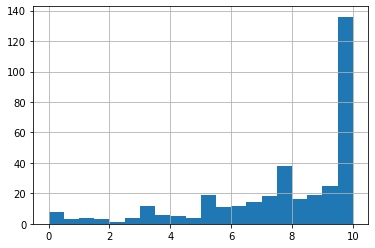

In [9]:
df_new['NOTE'].hist(bins=20)

In [10]:
#col = ['Moy_Pontage_de_fissures', 'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
#       'Moy_Longitudinale', 'Moy_Transversale', 'Moy_Remblaiement_de_tranchees',
#       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade']
col = ['Moy_Pontage', 'Moy_Comblage',
       'Moy_Longitudinale', 'Moy_Transversale',
       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade',
       'Moy_Remblaiement']

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_new[col]
scaler = StandardScaler()
X = scaler.fit_transform( X )
    
pca = PCA()
pca.fit(X)
new_feats = pca.transform(X)

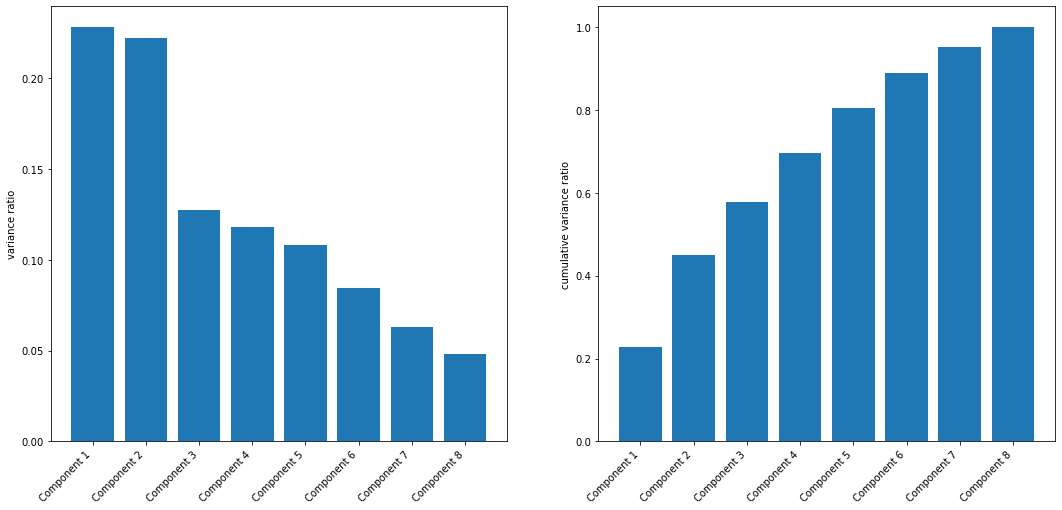

In [128]:
plt.figure(figsize=(18,8))

plt.subplot(1 ,2, 1)
var_ratio = pca.explained_variance_ratio_
plt.bar( range(len(var_ratio)), var_ratio )
plt.ylabel('variance ratio')
ticks = plt.xticks(ticks=[i for i in range(len(var_ratio))],
           labels=['Component {}'.format(i+1) for i in range(len(var_ratio))], rotation=45, ha='right')

plt.subplot(1 ,2, 2)
plt.bar( range(len(var_ratio)), np.cumsum(var_ratio) )
plt.ylabel('cumulative variance ratio')
ticks = plt.xticks(ticks=[i for i in range(len(var_ratio))],
           labels=['Component {}'.format(i+1) for i in range(len(var_ratio))], rotation=45, ha='right')

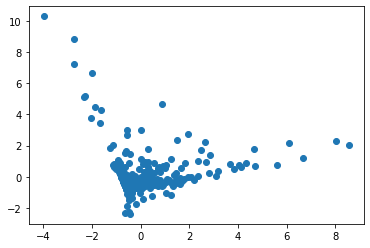

In [129]:
plt.scatter(new_feats[:,0], new_feats[:,1])

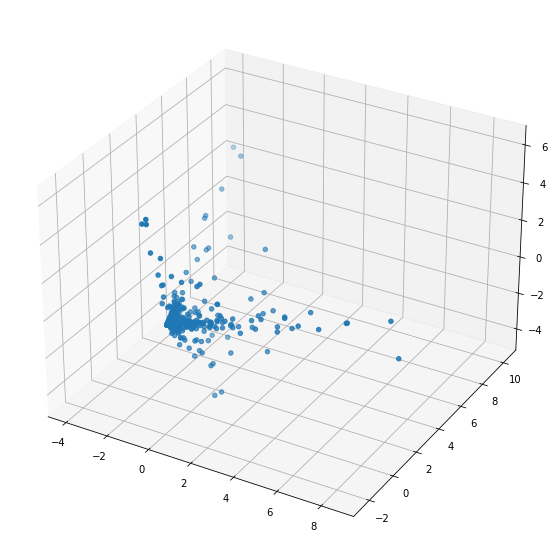

In [130]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(new_feats[:,0], new_feats[:,1], new_feats[:,2])

In [41]:
H, edges = np.histogramdd(new_feats[:,:2], bins=5)
H / H.sum()

array([[0.00558659, 0.13407821, 0.05586592, 0.01675978, 0.01396648],
       [0.02513966, 0.61452514, 0.03631285, 0.0027933 , 0.        ],
       [0.        , 0.04189944, 0.02513966, 0.        , 0.        ],
       [0.        , 0.00558659, 0.01396648, 0.        , 0.        ],
       [0.        , 0.        , 0.00837989, 0.        , 0.        ]])

In [ ]:
scipy.stats.binned_statistic_2d()

In [50]:
edges

[array([-0.59408164, -0.02779551,  0.53849062,  1.10477676,  1.67106289,
         2.23734902]),
 array([-0.80441746, -0.2366232 ,  0.33117105,  0.89896531,  1.46675956,
         2.03455382])]

In [57]:
edges = np.concatenate(edges).reshape(2,6)

In [68]:
from scipy.stats import binned_statistic_dd

In [135]:
stat, edges, binnumber = binned_statistic_dd(new_feats[:,:3], None, 'count', bins=5, expand_binnumbers=True)

In [136]:
stat

array([[[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   6.,   0.,   0.],
        [  0.,   0.,   1.,   1.,   0.],
        [  0.,   0.,   0.,   2.,   0.]],

       [[  0., 118., 118.,   7.,   4.],
        [  6.,  18.,  29.,   0.,   0.],
        [  1.,   0.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,  19.,   1.,   0.],
        [  0.,   5.,   7.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   8.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   3.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,

In [139]:
binnumber = binnumber - 1

In [145]:
binnumber[:,:2]

array([[1, 1],
       [0, 0],
       [1, 1]])

In [165]:
stat[tuple(binnumber)]

array([118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118.,
       118., 118., 118., 118., 118.,  29., 118., 118., 118.,  29., 118.,
       118., 118., 118., 118.,   1., 118., 118., 118., 118.,  29.,  29.,
        29.,  29., 118.,   6., 118., 118., 118., 118., 118., 118., 118.,
       118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118.,
        18.,   6., 118., 118.,  29., 118.,  29.,   7., 118., 118., 118.,
       118.,  18.,   5.,  29., 118., 118., 118., 118., 118., 118., 118.,
       118.,  18., 118., 118., 118.,  18., 118., 118., 118., 118.,   6.,
       118., 118., 118., 118., 118.,  18., 118., 118., 118., 118., 118.,
       118., 118.,  29., 118., 118., 118., 118.,   7., 118., 118.,   7.,
       118., 118.,   4.,   4.,   4.,   7.,   7.,   7.,   4., 118.,   7.,
       118., 118., 118., 118., 118.,   7., 118., 118., 118., 118., 118.,
       118.,  19., 118., 118., 118.,   1.,  19.,  19.,  19.,  19., 118.,
       118., 118., 118., 118., 118., 118., 118.,  2

In [33]:
df_new['Moy_sum'] = df_new[col].sum(axis=1)

<AxesSubplot:xlabel='NOTE', ylabel='Moy_sum'>

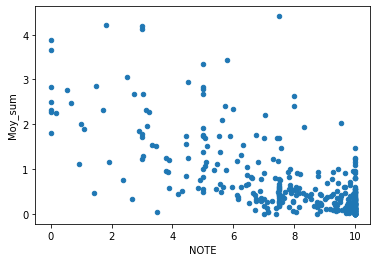

In [11]:
df_new.plot.scatter('NOTE', 'Moy_sum')

In [100]:
def note_vs_degradation(degr):
    plt.figure(figsize=(12,8))
    matrix, bins_x, bins_y = np.histogram2d(df_new[degr], df_new['NOTE'], bins=(10, 5))

    matrix = matrix / matrix.sum(axis=0)
#    print(matrix.T)
    plt.pcolor(matrix.T, cmap='Greens')
    plt.xticks(ticks=range(len(bins_x)), labels=bins_x)
    plt.yticks(ticks=range(len(bins_y)), labels=bins_y)
    plt.xlabel('Moyenne degradation')
    plt.ylabel('Note')
    plt.colorbar()
    plt.show()

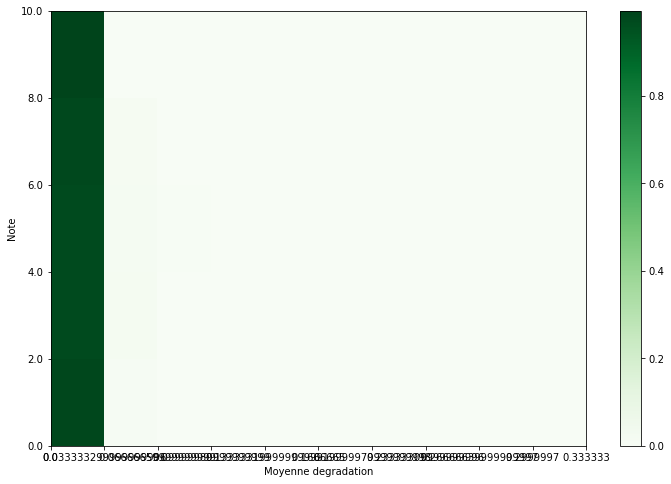

In [101]:
note_vs_degradation('Moy_Nid_de_poule')

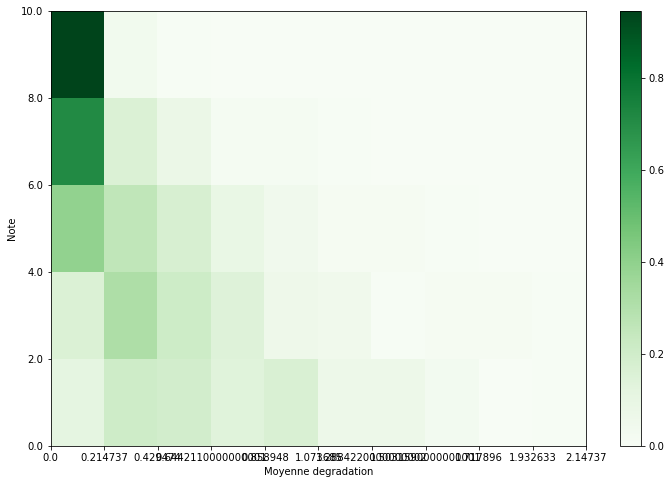

In [102]:
note_vs_degradation('Moy_Faiencage')

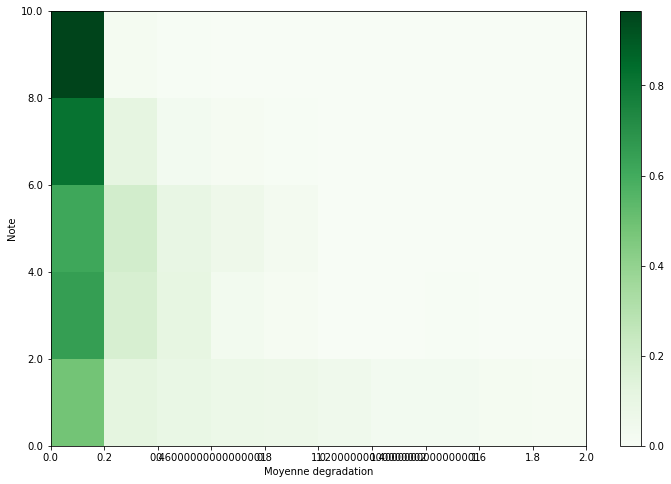

In [103]:
note_vs_degradation('Moy_Transversale')

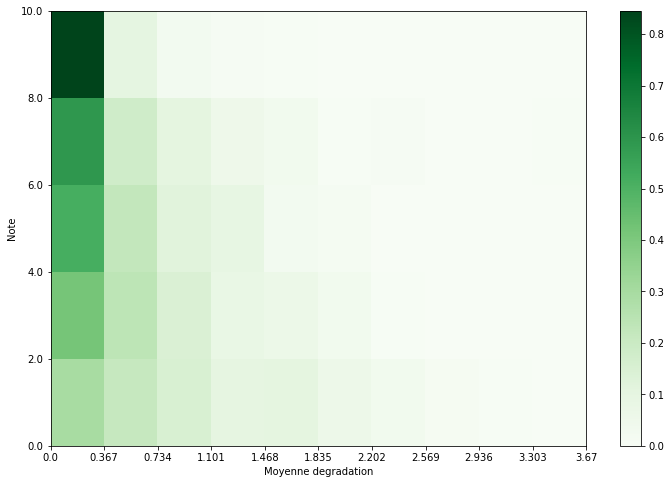

In [104]:
note_vs_degradation('Moy_Longitudinale')

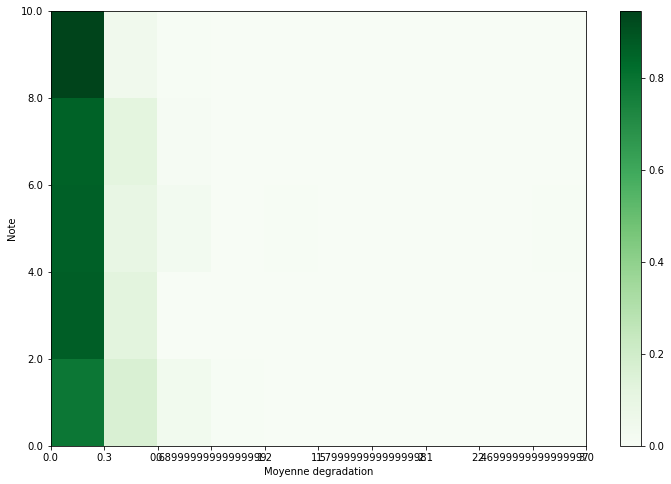

In [105]:
note_vs_degradation('Moy_Arrachement_pelade')

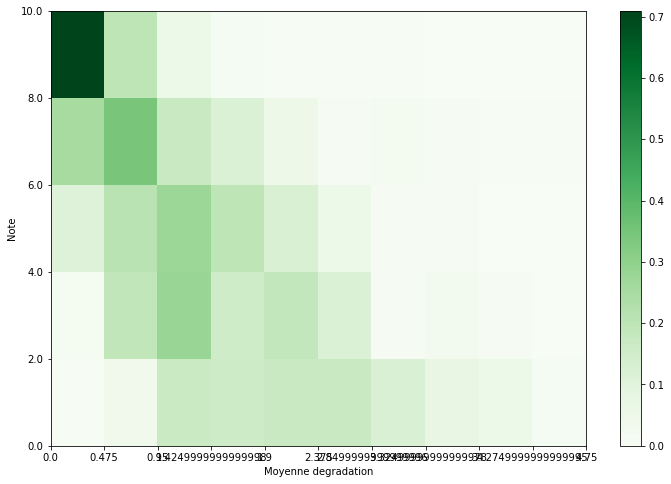

In [106]:
note_vs_degradation('Moy_sum')

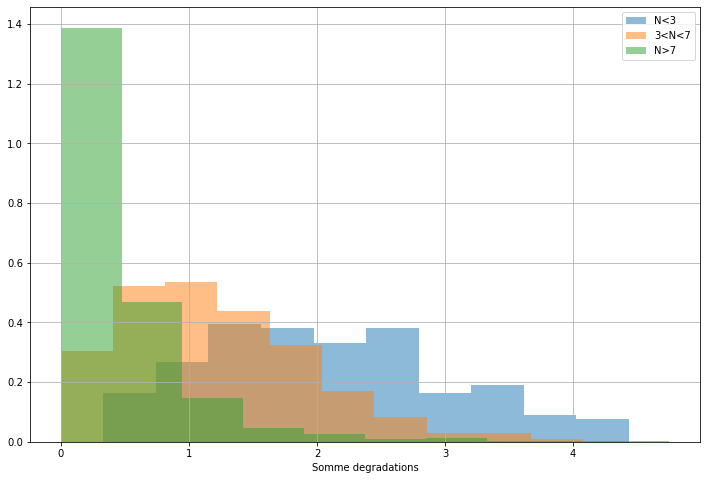

In [107]:
plt.figure(figsize=(12,8))
df_new[df_new['NOTE']<3]['Moy_sum'].hist(density=True, alpha=0.5, label='N<3')
df_new[(df_new['NOTE']>3) & (df_new['NOTE']<7)]['Moy_sum'].hist(density=True, alpha=0.5, label='3<N<7')
df_new[df_new['NOTE']>7]['Moy_sum'].hist(density=True, alpha=0.5, label='N>7')
plt.xlabel('Somme degradations')
plt.legend()

## Create fake data  
Generate fake data to test the network used to (try to) learn road grades

In [2]:
notes_fake = np.random.rand(5000)*10
degr_fake = np.random.normal(notes_fake, scale=notes_fake/10)/10
degr_fake = 1-np.clip(degr_fake, 0, 1)

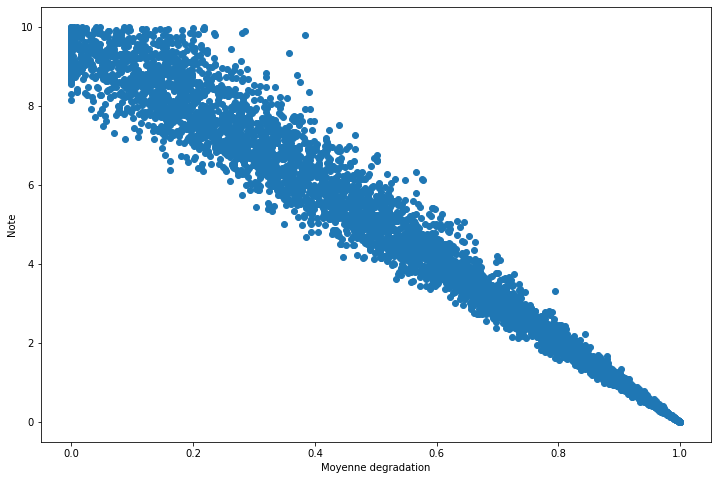

In [5]:
plt.figure(figsize=(12,8))
matrix, bins_x, bins_y = np.histogram2d(degr_fake, notes_fake, bins=(10, 5))

plt.scatter(degr_fake, notes_fake)
plt.xlabel('Moyenne degradation')
plt.ylabel('Note')
plt.show()

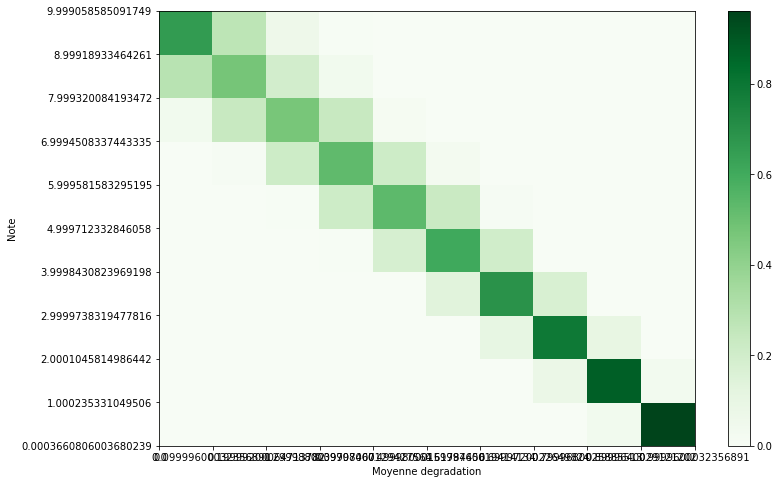

In [8]:
plt.figure(figsize=(12,8))
matrix, bins_x, bins_y = np.histogram2d(degr_fake, notes_fake, bins=(10, 10))

matrix = matrix / matrix.sum(axis=0)
#print(matrix.T)
plt.pcolor(matrix.T, cmap='Greens')
plt.xticks(ticks=range(len(bins_x)), labels=bins_x)
plt.yticks(ticks=range(len(bins_y)), labels=bins_y)
plt.xlabel('Moyenne degradation')
plt.ylabel('Note')
plt.colorbar()
plt.show()

In [9]:
df_fake = pd.DataFrame(notes_fake,columns=['NOTE'])

In [10]:
df_fake['Moy_degradation'] = degr_fake

In [11]:
df_fake[df_fake['NOTE']>9].std()

NOTE               0.290294
Moy_degradation    0.075025
dtype: float64

In [12]:
df_fake[df_fake['NOTE']<1].std()

NOTE               0.285833
Moy_degradation    0.029793
dtype: float64

In [13]:
df_fake[df_fake['Moy_degradation']>0.9].std()

NOTE               0.296017
Moy_degradation    0.028912
dtype: float64

In [14]:
df_fake[df_fake['Moy_degradation']<0.1].std()

NOTE               0.568350
Moy_degradation    0.034446
dtype: float64

In [13]:
df_fake

,NOTE,Moy_degradation
0,0.934347,0.907685
1,4.376851,0.635099
2,9.744482,0.076759
3,9.852082,0.107589
4,3.547437,0.668803
...,...,...
4995,4.188438,0.617034
4996,6.209426,0.505297
4997,1.028551,0.882834
4998,2.159203,0.771208


In [15]:
train_test_split_id = int(0.8 * df_fake.shape[0])
df_fake.to_csv('/home/thmegy/Téléchargements/notes_routes/fake_notes.csv', index=False)

In [166]:
df_fake['NOTE']

0       5.047454
1       3.283672
2       1.948243
3       4.695495
4       4.253721
          ...   
4995    6.125853
4996    0.252463
4997    2.539176
4998    6.912964
4999    5.702484
Name: NOTE, Length: 5000, dtype: float64

## Try sklearn methods

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [109]:
X = df_new.iloc[:,2:].values
y = df_new['NOTE']
#X = df_fake.iloc[:,1].values.reshape(-1,1)
#y = df_fake['NOTE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [110]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
metrics.mean_absolute_error(y_test, y_pred)

1.0392224616420398

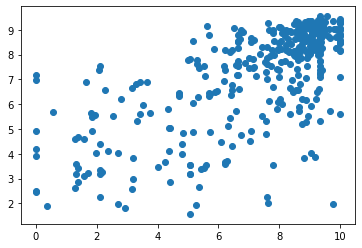

In [111]:
plt.scatter(y_test, y_pred)

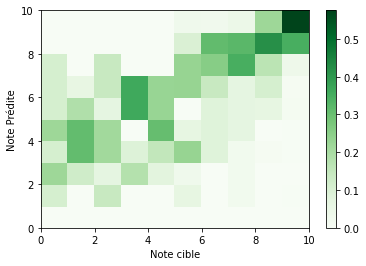

In [112]:
matrix, _, _ = np.histogram2d(y_pred, y_test, bins=(np.linspace(0, 10, 11),np.linspace(0, 10, 11)))
matrix = matrix / matrix.sum(axis=0)

fig3, ax3 = plt.subplots()
c = ax3.pcolor(matrix, cmap='Greens')
ax3.set_ylabel('Note Prédite')
ax3.set_xlabel('Note cible')
fig3.colorbar(c)

In [113]:
from sklearn.neural_network import MLPRegressor

In [114]:
reg = MLPRegressor(max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
metrics.mean_absolute_error(y_test, y_pred)

1.0188708777774031

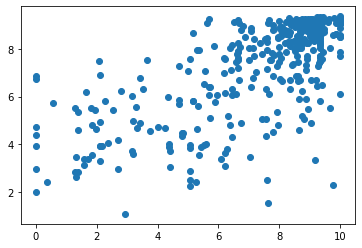

In [115]:
plt.scatter(y_test, y_pred)

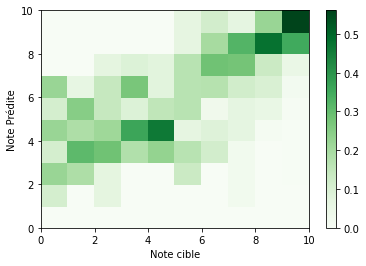

In [116]:
matrix, _, _ = np.histogram2d(y_pred, y_test, bins=(np.linspace(0, 10, 11),np.linspace(0, 10, 11)))
matrix = matrix / matrix.sum(axis=0)

fig3, ax3 = plt.subplots()
c = ax3.pcolor(matrix, cmap='Greens')
ax3.set_ylabel('Note Prédite')
ax3.set_xlabel('Note cible')
fig3.colorbar(c)

(array([  2.,   8.,  17.,  21.,  27.,  23.,  33.,  41.,  77., 283.]),
 array([1.09678269, 1.92305082, 2.74931894, 3.57558707, 4.4018552 ,
        5.22812332, 6.05439145, 6.88065958, 7.7069277 , 8.53319583,
        9.35946396]),
 <BarContainer object of 10 artists>)

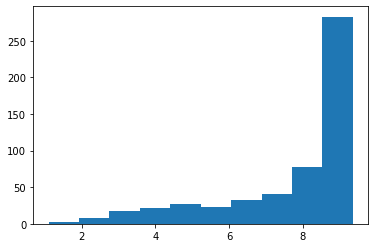

In [117]:
plt.hist(y_pred)

(array([314.,  89.,  58.,  33.,  17.,  10.,   5.,   2.,   1.,   3.]),
 array([5.24357321e-03, 7.52583295e-01, 1.49992302e+00, 2.24726274e+00,
        2.99460246e+00, 3.74194218e+00, 4.48928190e+00, 5.23662162e+00,
        5.98396135e+00, 6.73130107e+00, 7.47864079e+00]),
 <BarContainer object of 10 artists>)

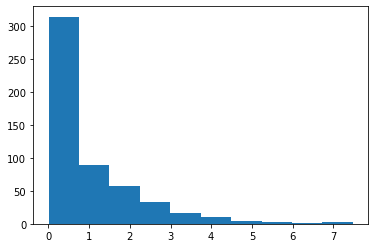

In [118]:
plt.hist(abs(y_test-y_pred))

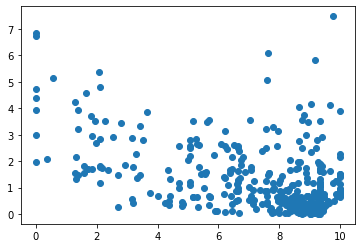

In [119]:
plt.scatter(y_test, abs(y_test-y_pred))